In [81]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

both_df = pd.read_csv("/home/azstephe/liverRegression/regression_liver/data/splits/macaqueMouse/macaqueToMouse_liver_macaqueEnhancer_mouseEnhancer_val_wawb.narrowPeak", sep="\t", header=None)
mac_qn = pd.read_csv("/home/azstephe/liverRegression/regression_liver/data/sorted_log_20615/quantile_norm/macaque_liver_pos_ALL.bed", sep="\t", header=None)
mouse_qn = pd.read_csv("/home/azstephe/liverRegression/regression_liver/data/sorted_log_20615/quantile_norm/mouse_liver_pos_ALL.bed", sep="\t", header=None)

unique1_2 = both_df[~both_df.duplicated(subset=[1, 2], keep=False)] # entries with unique mac mapped to mouse start and end
all_unique = unique1_2[~unique1_2.duplicated(subset=[11,12], keep=False)]

#### FUNCTIONS

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")
    
def collapse_if_identical(lst):
    return lst[0] if all(x == lst[0] for x in lst) else lst
    

# takes in list and returns peak with largest signal
def keep_largest_signal(lst, qn_df):
    if isinstance(lst, list):
        maxPeakName = ''
        maxPeakStrength = 0
        for peak in lst:
            matching_rows = qn_df[qn_df[3] == peak]
            if not matching_rows.empty:
                signal = matching_rows[4].iloc[0]
                if signal > maxPeakStrength:
                    maxPeakStrength = signal
                    maxPeakName = peak
        return maxPeakName
    else: 
        return lst

# def overlap(start1, end1, start2, end2):
#     return max(0, min(end1, end2)-max(start1, start2))

def get_biggest_overlap(lst, col, df):
    maxOverlap = 0
    maxPeakOverlap = ""
    for peak in lst:
        row = df[df[col] == peak].iloc[0] #iloc bc possible to return multiple rows (never will based on th
        overlap = max(0, min(row[2], row[12])-max(row[1], row[11]))
        if overlap > maxOverlap:
            maxOverlap = overlap
            maxPeakOverlap = peak
    return peak

#### COL1,2 DUPLICATES

duplicates3 = both_df[both_df.duplicated(subset=[1, 2], keep=False)] # entries with duplicated mac mapped to mouse start and end 
grouped_dups3 = duplicates3.groupby([1, 2])[3].apply(list).reset_index(name='col3')

# grouped dups: start | end | [peaks with these endpoints]
grouped_dups3['col3'] = grouped_dups3['col3'].apply(collapse_if_identical) 

grouped_dups3['col3'] = grouped_dups3['col3'].apply(lambda x: keep_largest_signal(x, mac_qn)) # redundant endpoints now map to 1 peak in col3
grouped_dups3 = grouped_dups3[grouped_dups3['col3'] != ''] # remove macaque peaks that aren't large enough (largest 20615)

# df of duplicated col1,2 with strongest peak
keep_strongestcol3 = duplicates3.merge(grouped_dups3[['col3']], left_on=3, right_on='col3', how='inner').drop('col3', axis=1) # keeps the strongest signal in col3 for redundant endpoints

#### COL11,12 DUPLICATES

grouped_dups13 = keep_strongestcol3.groupby([11, 12])[13].apply(list).reset_index(name='col13')
grouped_dups13['col13'] = grouped_dups13['col13'].apply(collapse_if_identical)

grouped_dups13['col13'] = grouped_dups13['col13'].apply(lambda x: keep_largest_signal(x, mouse_qn))
grouped_dups13 = grouped_dups13[grouped_dups13['col13'] != '']

keep_strongestcol13 = keep_strongestcol3.merge(grouped_dups13[['col13']], left_on=13, right_on='col13', how='inner').drop('col13', axis=1)

unique_endpoints = keep_strongestcol13 #rows with unique endpoints from the duplicated endpoints set

####

# col3 peakname duplicates with different endpoints
still_dups_col3 = unique_endpoints[unique_endpoints.duplicated(subset=[3], keep=False)]

# col3peaks | [col13 peaks intersecting col3 peak]
grouped_dcol3 = still_dups_col3.groupby(3)[13].apply(list).reset_index(name='col13')

# get the col13 peak with most overlap of col3
grouped_dcol3['col13'] = grouped_dcol3['col13'].apply(lambda x: get_biggest_overlap(x, 13, still_dups_col3))

merged3 = still_dups_col3.merge(grouped_dcol3[[3, 'col13']], left_on=[3, 13], right_on=[3, 'col13'], how='left', indicator=True)

remove3 = merged3[merged3['_merge'] == 'left_only'].drop(columns=['_merge']) # col13 is what we want to remove

unique_endpoints_subset = unique_endpoints.iloc[:,:20]
remove3_subset = remove3.iloc[:,:20]

# all col3 entries unique
unique3 = unique_endpoints[~unique_endpoints_subset.apply(tuple, axis=1).isin(remove3_subset.apply(tuple, axis=1))] 

####

# col13 peakname duplicates with different endpoints
still_dups_col13 = unique3[unique3.duplicated(subset=[13], keep=False)]

# col13peaks | [col3 peaks intersecting col13 peak]
grouped_dcol13 = still_dups_col13.groupby(13)[3].apply(list).reset_index(name='col3')

# get the col3 peak with most overlap of col13
grouped_dcol13['col3'] = grouped_dcol13['col3'].apply(lambda x: get_biggest_overlap(x, 3, still_dups_col13))

merged13 = still_dups_col13.merge(grouped_dcol13[[13, 'col3']], left_on=[3, 13], right_on=['col3', 13], how='left', indicator=True)

remove13 = merged13[merged13['_merge'] == 'left_only'].drop(columns=['_merge'])

unique3_subset = unique3.iloc[:, :20]
remove13_subset = remove13.iloc[:, :20]

# Identify rows in u3 that are NOT in remove3
filtered_peaks_unique = unique3[~unique3_subset.apply(tuple, axis=1).isin(remove13_subset.apply(tuple, axis=1))]

# one_to_one_peaks = pd.concat(all_unique, filtered_peaks_unique)

full_unique = pd.concat([all_unique, filtered_peaks_unique])

# Sort by column '1'
one_to_one_peaks = full_unique.sort_values(by=1).reset_index(drop=True)
one_to_one_peaks

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,chr9,6668262,6668828,peak24458,-1,.,-1,-1,-1,370,chr9,6668246,6669123,peak20464,1000,.,10.41801,106.98440,104.00175,372
1,chr9,7603389,7603594,peak64793,-1,.,-1,-1,-1,114,chr9,7603184,7603794,peak20478,1000,.,18.10567,247.44370,243.99432,315
2,chr9,7914492,7914988,peak729,-1,.,-1,-1,-1,141,chr9,7914173,7914971,peak20484,1000,.,15.21739,160.17427,156.98676,531
3,chr8,8733638,8734157,peak30058,-1,.,-1,-1,-1,379,chr8,8733751,8734148,peak19418,1000,.,12.36603,110.58308,107.58508,270
4,chr8,8992445,8993220,peak5261,-1,.,-1,-1,-1,506,chr8,8992509,8993074,peak19424,1000,.,6.54450,48.63282,45.97403,451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,chr8,126774794,126775271,peak24665,-1,.,-1,-1,-1,309,chr8,126774776,126775173,peak20427,884,.,5.10220,22.43992,20.03460,168
247,chr8,126807358,126807991,peak39634,-1,.,-1,-1,-1,136,chr8,126807232,126807976,peak20428,921,.,5.94463,33.65896,31.12857,206
248,chr8,126824543,126825031,peak57495,-1,.,-1,-1,-1,266,chr8,126824525,126825188,peak20431,1000,.,6.61796,38.65833,36.08059,314
249,chr8,126920866,126921347,peak14712,-1,.,-1,-1,-1,189,chr8,126920865,126921188,peak20441,1000,.,6.42499,33.74764,31.21361,172


In [61]:
real_qn_mouse = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/sorted_log_20615/quantile_norm/mouse_liver_pos_ALL.bed', header=None, sep='\t')
real_qn_mac = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/sorted_log_20615/quantile_norm/macaque_liver_pos_ALL.bed', header=None, sep='\t')
peaks = one_to_one_peaks[[3, 13]]

merged_df = peaks.merge(real_qn_mac, how='left', left_on=3, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(real_qn_mouse, how='left', left_on=13, right_on=3, suffixes=('_mac', '_mouse'))

# Subtract col4 values from df2 and df3
merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
res = merged_df[['3_mac', 13, '4_mac', '4_mouse', 'result']]
nan = res[res.isna().any(axis=1)]
nan

,3_mac,13,4_mac,4_mouse,result
5,peak78336,peak19426,NaN,2.034350,NaN
7,peak85535,peak19435,NaN,2.631485,NaN
11,peak50774,peak19453,NaN,2.559871,NaN
18,peak83455,peak20543,NaN,2.232538,NaN
22,peak66060,peak19505,NaN,2.622576,NaN
23,peak81614,peak19522,NaN,2.945637,NaN
37,peak71752,peak20683,NaN,2.273389,NaN
55,peak77950,peak19635,NaN,3.056199,NaN
61,peak73561,peak20750,NaN,2.622848,NaN
63,peak96492,peak20752,NaN,2.096311,NaN


In [72]:
pred_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/model_outputs/ylfry2wl/activations_macaque_VAL.csv', header=None)
val1_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val1/macaque_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val2_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val2/macaque_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val3/macaque_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val2/macaque_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

# neg_df = pd.read_csv('../splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', header=None, delim_whitespace=True).iloc[:,4]
# neg_len = len(neg_df)
# doubled_ndf = pd.DataFrame(np.zeros((neg_len*2, 1)))
doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)
mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_real', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=3, right_on=3).drop(13, axis=1)
m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = m_mac_pred.rename(columns={'true':'mac_real', 'pred':'mac_pred', 3:'mac_peak'})
m_mac_pred

,mac_peak,mac_chr,1,2,mac_real,mac_pred
0,peak24458,chr14,96572066.0,96572566.0,2.599997,2.202524
1,peak24458,chr14,96572066.0,96572566.0,2.599997,2.205888
2,peak64793,chr14,95561698.0,95562198.0,1.832866,2.200734
3,peak64793,chr14,95561698.0,95562198.0,1.832866,2.196278
4,peak729,chr14,95163729.0,95164229.0,3.341600,2.228029
...,...,...,...,...,...,...
427,peak39634,chr1,211201073.0,211201573.0,1.862402,2.034699
428,peak14712,chr1,211365516.0,211366016.0,2.881346,2.124989
429,peak14712,chr1,211365516.0,211366016.0,2.881346,2.145060
430,peak11504,chr9,35000894.0,35001394.0,3.076468,2.068533


In [73]:
mouse_pred = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/model_outputs/ylfry2wl/activations_mouse_VAL_TRAIN_batch.csv', sep="\t", header=None)
mouse_pred_pos = mouse_pred[:3760]
mouse_pred_neg = mouse_pred[3760:]
mouse_real_pos = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/sorted_log_20615/splits/mousePos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)
mouse_real_neg = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_mouse_real_neg = pd.concat([mouse_real_neg, mouse_real_neg]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_real = pd.concat([mouse_real_pos, mouse_real_neg], axis=1)

doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_real', 0:'mouse_pred'}).reset_index(drop=True)

merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=13, right_on=3)

m_mouse_pred = merged_mouse_pred[~merged_mouse_pred[13].isin(nan[13])].reset_index(drop=True)
m_mouse_pred = m_mouse_pred.rename(columns={'real':'mouse_true', 'pred':'mouse_pred', 13:'mouse_peak'}).drop(['3_y'], axis=1)
m_mouse_pred

,3_x,mouse_peak,mouse_chr,1,2,mouse_real,mouse_pred
0,peak24458,peak20464,chr9,6668368,6668868,2.585922,2.137022
1,peak24458,peak20464,chr9,6668368,6668868,2.585922,2.132301
2,peak64793,peak20478,chr9,7603249,7603749,3.056738,2.201391
3,peak64793,peak20478,chr9,7603249,7603749,3.056738,2.192470
4,peak729,peak20484,chr9,7914454,7914954,2.898484,2.149366
...,...,...,...,...,...,...,...
427,peak39634,peak20428,chr8,126807188,126807688,2.167768,1.993827
428,peak14712,peak20441,chr8,126920787,126921287,2.225973,2.210719
429,peak14712,peak20441,chr8,126920787,126921287,2.225973,2.182461
430,peak11504,peak20442,chr8,127104567,127105067,2.425371,2.059245


In [76]:
bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)
bigboss['true'] = bigboss['mouse_real']-bigboss['mac_real']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']
bigboss

,3_x,mouse_peak,mouse_chr,1,2,mouse_real,mouse_pred,mac_peak,mac_chr,1,2,mac_real,mac_pred,true,pred
0,peak24458,peak20464,chr9,6668368,6668868,2.585922,2.137022,peak24458,chr14,96572066.0,96572566.0,2.599997,2.202524,-0.014075,-0.065502
1,peak24458,peak20464,chr9,6668368,6668868,2.585922,2.132301,peak24458,chr14,96572066.0,96572566.0,2.599997,2.205888,-0.014075,-0.073588
2,peak64793,peak20478,chr9,7603249,7603749,3.056738,2.201391,peak64793,chr14,95561698.0,95562198.0,1.832866,2.200734,1.223872,0.000657
3,peak64793,peak20478,chr9,7603249,7603749,3.056738,2.192470,peak64793,chr14,95561698.0,95562198.0,1.832866,2.196278,1.223872,-0.003808
4,peak729,peak20484,chr9,7914454,7914954,2.898484,2.149366,peak729,chr14,95163729.0,95164229.0,3.341600,2.228029,-0.443116,-0.078663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,peak39634,peak20428,chr8,126807188,126807688,2.167768,1.993827,peak39634,chr1,211201073.0,211201573.0,1.862402,2.034699,0.305366,-0.040872
428,peak14712,peak20441,chr8,126920787,126921287,2.225973,2.210719,peak14712,chr1,211365516.0,211366016.0,2.881346,2.124989,-0.655373,0.085731
429,peak14712,peak20441,chr8,126920787,126921287,2.225973,2.182461,peak14712,chr1,211365516.0,211366016.0,2.881346,2.145060,-0.655373,0.037401
430,peak11504,peak20442,chr8,127104567,127105067,2.425371,2.059245,peak11504,chr9,35000894.0,35001394.0,3.076468,2.068533,-0.651097,-0.009288


In [77]:
same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
same_sign.sum()

226

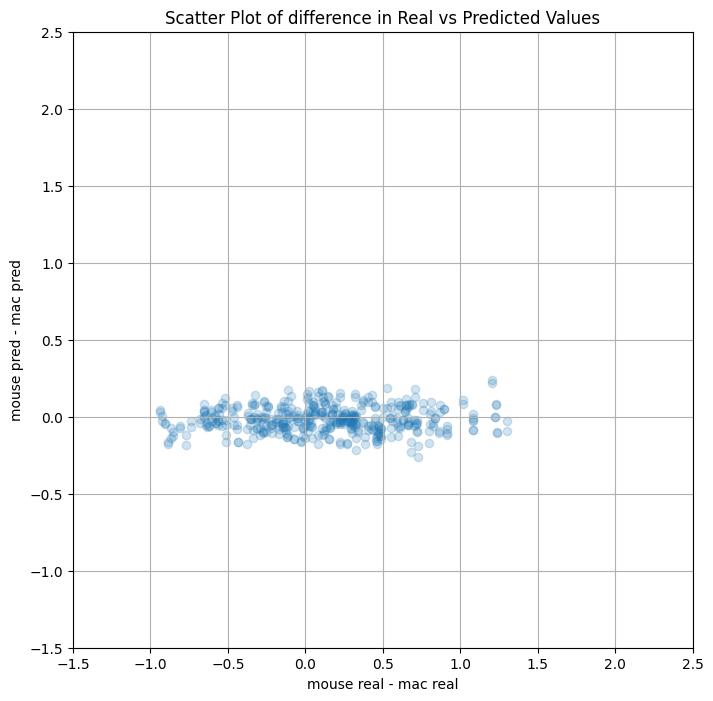

Pearson correlation coefficient: 0.0531, p-value: 0.271
Spearman correlation coefficient: 0.0196, p-value: 0.684


In [82]:
x = bigboss['true']
y=bigboss['pred']
plt.figure(figsize=(8, 8))
plt.axis([-1.5, 2.5, -1.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel('mouse real - mac real')
plt.ylabel('mouse pred - mac pred')
plt.title('Scatter Plot of difference in Real vs Predicted Values')
plt.grid(True)
plt.show()
pearson_spearman(x, y)

In [86]:
mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_true'] = bigboss['mouse_real']-bigboss['mac_real']
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']

# old_bigboss['avg_true'] = old_bigboss['mouse_real']-old_bigboss['mac_real']
# old_bigboss['avg_pred'] = old_bigboss['mouse_pred_avg']-old_bigboss['mac_pred_avg']
# old_bigboss

same_sign = np.sign(bigboss.loc[::2]['avg_true']) == np.sign(bigboss.loc[::2]['avg_pred'])
same_sign.sum()

111

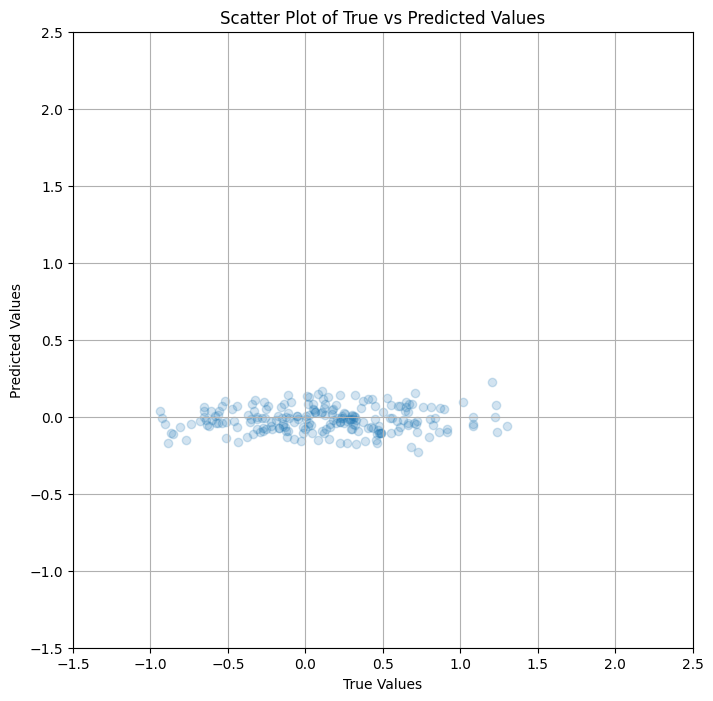

Pearson correlation coefficient: 0.0547, p-value: 0.4235
Spearman correlation coefficient: 0.0191, p-value: 0.7803


In [87]:
x = bigboss['avg_true']
y=bigboss['avg_pred']


plt.figure(figsize=(8, 8))
plt.axis([-1.5, 2.5, -1.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.grid(True)
plt.show()
pearson_spearman(x[::2], y[::2])

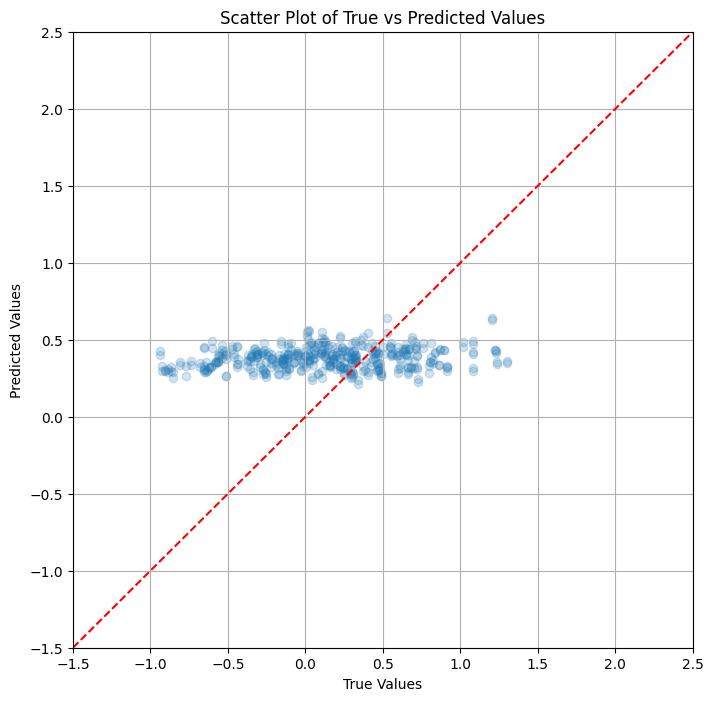

Pearson correlation coefficient: 0.1772, p-value: 0.000214
Spearman correlation coefficient: 0.1470, p-value: 0.002194
266
133


In [104]:
pred_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/model_outputs/or2bctq6/activations_macaque_VAL.csv', header=None)
val2_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val2/macaque_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0:'old_mac_chr', 3:'mac_peak', 4:'mac_real'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

mac_all = pd.concat([doubled_val2_df, pred_val2_df], axis=1).rename(columns={0:'mac_pred'})

merged_mac = peaks.merge(mac_all, how='left', left_on=3, right_on='mac_peak')
nan = merged_mac[merged_mac.isna().any(axis=1)]
m_mac_old = merged_mac[~merged_mac[3].isin(nan[3])].reset_index(drop=True)
m_mouse_old = merged_mouse_pred[~merged_mouse_pred[13].isin(nan[13])].reset_index(drop=True)
m_mouse_old = m_mouse_old.rename(columns={'real':'mouse_real', '3_y':"mouse_peak", 'pred':'mouse_pred'})
or_bigboss =pd.concat([m_mac_old, m_mouse_old], axis=1)

or_bigboss['true'] = old_bigboss['mouse_real']-or_bigboss['mac_real']
or_bigboss['pred'] = old_bigboss['mouse_pred']-or_bigboss['mac_pred']

x = or_bigboss['true']
y = or_bigboss['pred']

plt.figure(figsize=(8, 8))
plt.axis([-1.5, 2.5, -1.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.plot([-1.5, 2.5], [-1.5, 2.5], color='red', linestyle='--', label='y = x')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.grid(True)
plt.show()
pearson_spearman(x, y)

same_sign = np.sign(or_bigboss['true']) == np.sign(or_bigboss['pred'])
print(same_sign.sum())
mouse_av = (or_bigboss.loc[::2, 'mouse_pred'].values + or_bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (or_bigboss.loc[::2, 'mac_pred'].values + or_bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
or_bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
or_bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
or_bigboss['avg_true'] = bigboss['mouse_real']-or_bigboss['mac_real']
or_bigboss['avg_pred'] = bigboss['mouse_pred_avg']-or_bigboss['mac_pred_avg']

same_sign = np.sign(or_bigboss.loc[::2]['avg_true']) == np.sign(or_bigboss.loc[::2]['avg_pred'])
print(same_sign.sum())

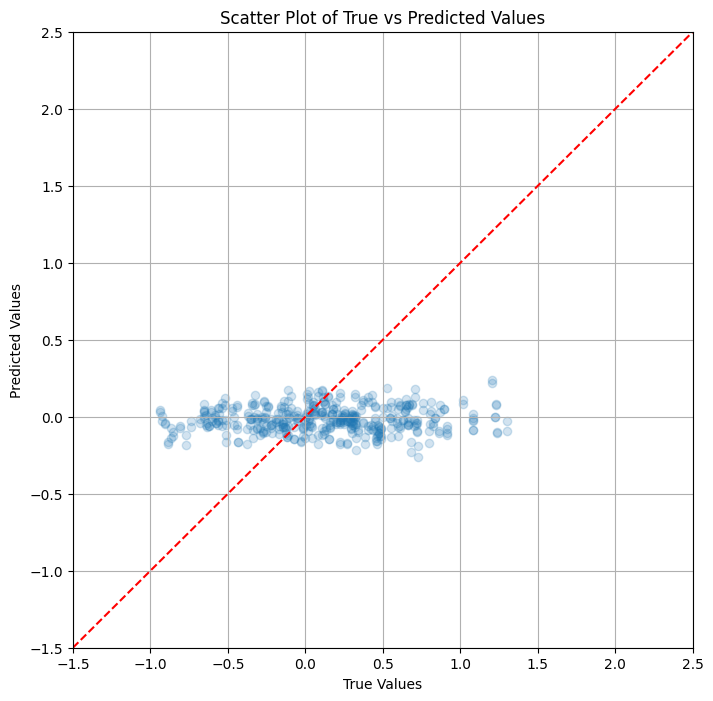

Pearson correlation coefficient: 0.0531, p-value: 0.271
Spearman correlation coefficient: 0.0196, p-value: 0.684
226
111


In [105]:
pred_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/model_outputs/ylfry2wl/activations_macaque_VAL.csv', header=None)
val2_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val2/macaque_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0:'old_mac_chr', 3:'mac_peak', 4:'mac_real'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

mac_all = pd.concat([doubled_val2_df, pred_val2_df], axis=1).rename(columns={0:'mac_pred'})

merged_mac = peaks.merge(mac_all, how='left', left_on=3, right_on='mac_peak')
nan = merged_mac[merged_mac.isna().any(axis=1)]
m_mac_old = merged_mac[~merged_mac[3].isin(nan[3])].reset_index(drop=True)
m_mouse_old = merged_mouse_pred[~merged_mouse_pred[13].isin(nan[13])].reset_index(drop=True)
m_mouse_old = m_mouse_old.rename(columns={'real':'mouse_real', '3_y':"mouse_peak", 'pred':'mouse_pred'})
or_bigboss =pd.concat([m_mac_old, m_mouse_old], axis=1)

or_bigboss['true'] = old_bigboss['mouse_real']-or_bigboss['mac_real']
or_bigboss['pred'] = old_bigboss['mouse_pred']-or_bigboss['mac_pred']

x = or_bigboss['true']
y = or_bigboss['pred']

plt.figure(figsize=(8, 8))
plt.axis([-1.5, 2.5, -1.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.plot([-1.5, 2.5], [-1.5, 2.5], color='red', linestyle='--', label='y = x')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.grid(True)
plt.show()
pearson_spearman(x, y)

same_sign = np.sign(or_bigboss['true']) == np.sign(or_bigboss['pred'])
print(same_sign.sum())
mouse_av = (or_bigboss.loc[::2, 'mouse_pred'].values + or_bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (or_bigboss.loc[::2, 'mac_pred'].values + or_bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
or_bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
or_bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
or_bigboss['avg_true'] = bigboss['mouse_real']-or_bigboss['mac_real']
or_bigboss['avg_pred'] = bigboss['mouse_pred_avg']-or_bigboss['mac_pred_avg']

same_sign = np.sign(or_bigboss.loc[::2]['avg_true']) == np.sign(or_bigboss.loc[::2]['avg_pred'])
print(same_sign.sum())

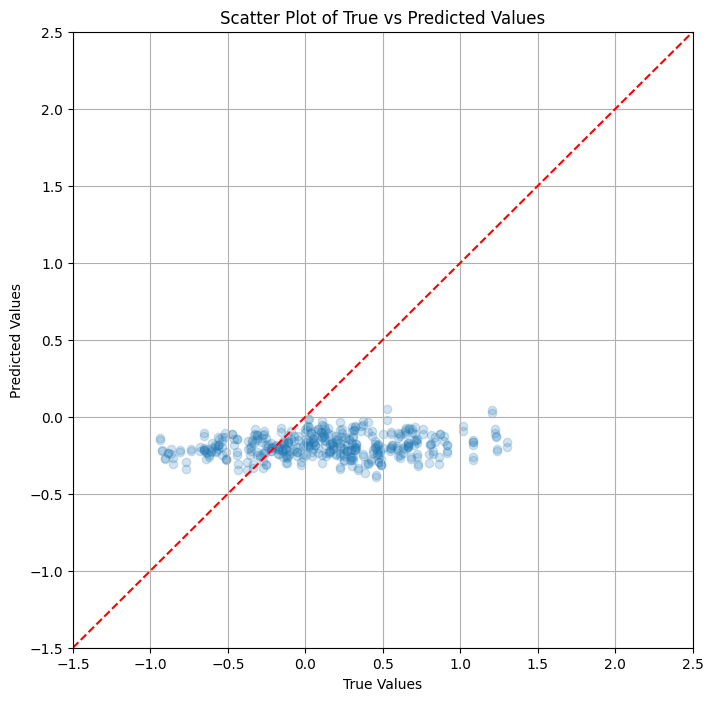

Pearson correlation coefficient: 0.1617, p-value: 0.0007445
Spearman correlation coefficient: 0.1344, p-value: 0.005152
169
85


In [106]:
pred_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/model_outputs/r5ibvwem/activations_macaque_VAL.csv', header=None)
val2_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val2/macaque_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0:'old_mac_chr', 3:'mac_peak', 4:'mac_real'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

mac_all = pd.concat([doubled_val2_df, pred_val2_df], axis=1).rename(columns={0:'mac_pred'})

merged_mac = peaks.merge(mac_all, how='left', left_on=3, right_on='mac_peak')
nan = merged_mac[merged_mac.isna().any(axis=1)]
m_mac_old = merged_mac[~merged_mac[3].isin(nan[3])].reset_index(drop=True)
m_mouse_old = merged_mouse_pred[~merged_mouse_pred[13].isin(nan[13])].reset_index(drop=True)
m_mouse_old = m_mouse_old.rename(columns={'real':'mouse_real', '3_y':"mouse_peak", 'pred':'mouse_pred'})
or_bigboss =pd.concat([m_mac_old, m_mouse_old], axis=1)

or_bigboss['true'] = old_bigboss['mouse_real']-or_bigboss['mac_real']
or_bigboss['pred'] = old_bigboss['mouse_pred']-or_bigboss['mac_pred']

x = or_bigboss['true']
y = or_bigboss['pred']

plt.figure(figsize=(8, 8))
plt.axis([-1.5, 2.5, -1.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.plot([-1.5, 2.5], [-1.5, 2.5], color='red', linestyle='--', label='y = x')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.grid(True)
plt.show()
pearson_spearman(x, y)

same_sign = np.sign(or_bigboss['true']) == np.sign(or_bigboss['pred'])
print(same_sign.sum())
mouse_av = (or_bigboss.loc[::2, 'mouse_pred'].values + or_bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (or_bigboss.loc[::2, 'mac_pred'].values + or_bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
or_bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
or_bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
or_bigboss['avg_true'] = bigboss['mouse_real']-or_bigboss['mac_real']
or_bigboss['avg_pred'] = bigboss['mouse_pred_avg']-or_bigboss['mac_pred_avg']

same_sign = np.sign(or_bigboss.loc[::2]['avg_true']) == np.sign(or_bigboss.loc[::2]['avg_pred'])
print(same_sign.sum())